In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as tf
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [2]:
dfi = pd.read_csv('./Data/madrid.csv')
dfi

,Unnamed: 0,time,temperature,wind_speed,wind_direction,humidity,barometric_pressure,solar_radiation,precipitation
0,0,2019-01-01 00:59:59,3.1,0.65,64.0,50.0,949.0,0.0,0.0
1,1,2019-01-01 01:59:59,2.9,0.95,32.0,49.0,949.0,0.0,0.0
2,2,2019-01-01 02:59:59,3.1,0.87,62.0,46.0,949.0,0.0,0.0
3,3,2019-01-01 03:59:59,1.9,0.73,75.0,51.0,949.0,0.0,0.0
4,4,2019-01-01 04:59:59,0.7,0.57,53.0,56.0,949.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
27019,715,2022-01-31 19:59:59,10.1,2.65,47.0,17.0,946.0,0.0,0.0
27020,716,2022-01-31 20:59:59,8.2,3.82,21.0,25.0,947.0,0.0,0.0
27021,717,2022-01-31 21:59:59,7.2,2.38,29.0,31.0,947.0,0.0,0.0
27022,718,2022-01-31 22:59:59,5.6,3.92,58.0,41.0,947.0,0.0,0.0


In [3]:
df = dfi.loc[dfi['time'] < '2019-08-01']
df

,Unnamed: 0,time,temperature,wind_speed,wind_direction,humidity,barometric_pressure,solar_radiation,precipitation
0,0,2019-01-01 00:59:59,3.1,0.65,64.0,50.0,949.0,0.0,0.0
1,1,2019-01-01 01:59:59,2.9,0.95,32.0,49.0,949.0,0.0,0.0
2,2,2019-01-01 02:59:59,3.1,0.87,62.0,46.0,949.0,0.0,0.0
3,3,2019-01-01 03:59:59,1.9,0.73,75.0,51.0,949.0,0.0,0.0
4,4,2019-01-01 04:59:59,0.7,0.57,53.0,56.0,949.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5083,739,2019-07-31 19:59:59,29.3,2.88,122.0,25.0,937.0,230.0,0.0
5084,740,2019-07-31 20:59:59,27.7,5.18,106.0,35.0,937.0,29.0,0.0
5085,741,2019-07-31 21:59:59,25.7,5.98,122.0,43.0,937.0,1.0,0.0
5086,742,2019-07-31 22:59:59,24.5,5.62,133.0,47.0,938.0,0.0,0.0


In [4]:
df = df[['barometric_pressure','wind_speed','humidity','temperature']]
df = df.dropna()
df = df.reset_index(drop=True)
df

,barometric_pressure,wind_speed,humidity,temperature
0,949.0,0.65,50.0,3.1
1,949.0,0.95,49.0,2.9
2,949.0,0.87,46.0,3.1
3,949.0,0.73,51.0,1.9
4,949.0,0.57,56.0,0.7
...,...,...,...,...
5083,937.0,2.88,25.0,29.3
5084,937.0,5.18,35.0,27.7
5085,937.0,5.98,43.0,25.7
5086,938.0,5.62,47.0,24.5


In [5]:
df['nxt_target'] = df['temperature'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5088 entries, 0 to 5087
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   barometric_pressure  5088 non-null   float64
 1   wind_speed           5088 non-null   float64
 2   humidity             5088 non-null   float64
 3   temperature          5088 non-null   float64
 4   nxt_target           5088 non-null   float64
dtypes: float64(5)
memory usage: 198.9 KB


In [7]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,barometric_pressure,wind_speed,humidity,temperature,nxt_target
0,949.0,0.65,50.0,3.1,2.9
1,949.0,0.95,49.0,2.9,3.1
2,949.0,0.87,46.0,3.1,1.9
3,949.0,0.73,51.0,1.9,0.7
4,949.0,0.57,56.0,0.7,0.5
...,...,...,...,...,...
4065,939.0,3.10,53.0,16.8,17.5
4066,939.0,3.97,51.0,17.5,17.9
4067,939.0,4.02,49.0,17.9,18.8
4068,940.0,3.57,46.0,18.8,19.5


In [8]:
train.iloc[:,-1:]

,nxt_target
0,2.9
1,3.1
2,1.9
3,0.7
4,0.5
...,...
4065,17.5
4066,17.9
4067,18.8
4068,19.5


In [9]:
train.iloc[:,:4]

,barometric_pressure,wind_speed,humidity,temperature
0,949.0,0.65,50.0,3.1
1,949.0,0.95,49.0,2.9
2,949.0,0.87,46.0,3.1
3,949.0,0.73,51.0,1.9
4,949.0,0.57,56.0,0.7
...,...,...,...,...
4065,939.0,3.10,53.0,16.8
4066,939.0,3.97,51.0,17.5
4067,939.0,4.02,49.0,17.9
4068,940.0,3.57,46.0,18.8


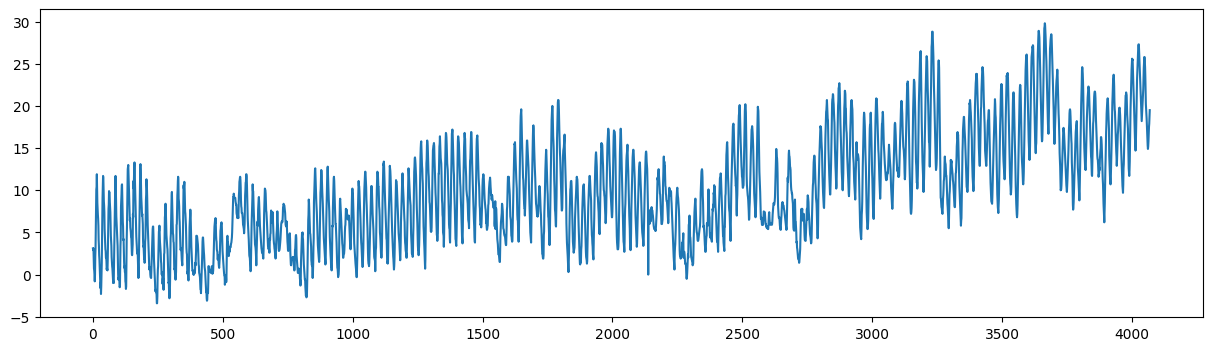

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["temperature"])
plt.show()

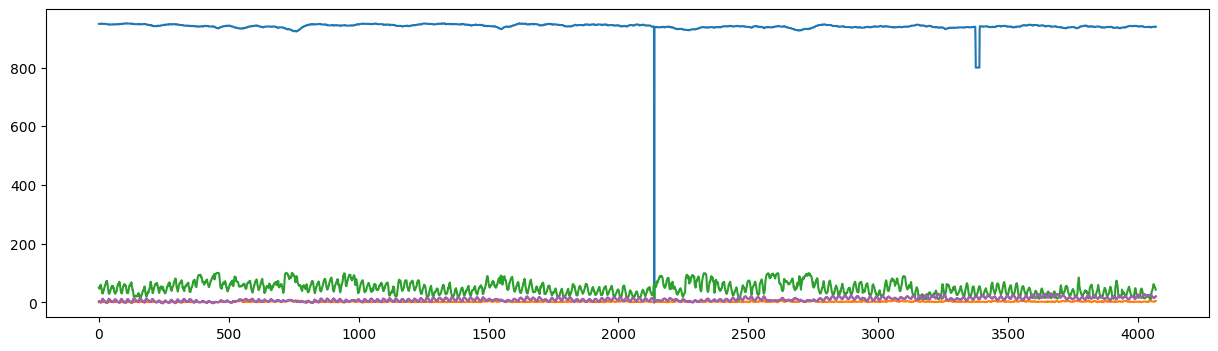

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [12]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [13]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [14]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
print(X_train.shape)
batch_size, seq_length, features_size =X_train.size()
print(batch_size)
X_train[0][0]

torch.Size([4060, 10, 4])
4060


tensor([ 0.4751, -1.1074,  0.0809, -1.0663])

In [17]:
device = "cpu"

In [18]:
def init_hidden(x: torch.Tensor, hidden_size: int, num_dir: int = 1, xavier: bool = True):
    
    if xavier:
        return nn.init.xavier_normal_(torch.zeros(num_dir, x.size(0), hidden_size)).to(device)
    return Variable(torch.zeros(num_dir, x.size(0), hidden_size)).to(device)

In [19]:
class AttnEncoder(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, batch_first: bool = True,seq_len:int=10):
        
        super(AttnEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=1
        )
        self.attn = nn.Linear(
            in_features=2 * self.hidden_size + self.seq_len,
            out_features=1
        )
        self.softmax = nn.Softmax(dim=1)

    
    def forward(self, input_data: torch.Tensor):
        
        h_t, c_t = (init_hidden(input_data, self.hidden_size),
                    init_hidden(input_data, self.hidden_size))

        attentions, input_encoded = (Variable(torch.zeros(input_data.size(0), self.seq_len, self.input_size)),
                                     Variable(torch.zeros(input_data.size(0), self.seq_len, self.hidden_size)))

        
        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           input_data.permute(0, 2, 1).to(device)), dim=2).to(
                device)  # bs * input_size * (2 * hidden_dim + seq_len)

            e_t = self.attn(x.view(-1, self.hidden_size * 2 + self.seq_len))  # (bs * input_size) * 1
            a_t = self.softmax(e_t.view(-1, self.input_size)).to(device)  # (bs, input_size)

            weighted_input = torch.mul(a_t, input_data[:, t, :].to(device))  # (bs * input_size)
            self.lstm.flatten_parameters()
            _, (h_t, c_t) = self.lstm(weighted_input.unsqueeze(0), (h_t, c_t))

            input_encoded[:, t, :] = h_t
            attentions[:, t, :] = a_t

        return attentions, input_encoded

In [20]:
class AttnDecoder(nn.Module):
    def __init__(self,  hidden_size: int, batch_first: bool = True,seq_len:int=10):
        
        super(AttnDecoder, self).__init__()
        self.seq_len = seq_len
        self.encoder_hidden_size = hidden_size
        self.decoder_hidden_size = hidden_size
        self.out_feats = 1

        self.attn = nn.Sequential(
            nn.Linear(2 * self.decoder_hidden_size + self.encoder_hidden_size, self.encoder_hidden_size),
            nn.Tanh(),
            nn.Linear(self.encoder_hidden_size, 1)
        )
        self.lstm = nn.LSTM(input_size=self.out_feats, hidden_size=self.decoder_hidden_size)
        self.fc = nn.Linear(self.encoder_hidden_size + self.out_feats, self.out_feats)
        self.fc_out = nn.Linear(self.decoder_hidden_size + self.encoder_hidden_size, self.out_feats)
        self.fc.weight.data.normal_()

    def forward(self, input_encoded: torch.Tensor, y_history: torch.Tensor):
        
        h_t, c_t = (
            init_hidden(input_encoded, self.decoder_hidden_size), init_hidden(input_encoded, self.decoder_hidden_size))
        context = Variable(torch.zeros(input_encoded.size(0), self.encoder_hidden_size))

        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           input_encoded.to(device)), dim=2)

            x = tf.softmax(
                self.attn(
                    x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size)
                ).view(-1, self.seq_len),
                dim=1)

            context = torch.bmm(x.unsqueeze(1), input_encoded.to(device))[:, 0, :]  # (batch_size, encoder_hidden_size)
            #print('context yhis',context.to(device).size(), y_history.to(device).size())
            y_tilde = self.fc(torch.cat((context.to(device), y_history.to(device)),
                                        dim=1))  # (batch_size, out_size)

            self.lstm.flatten_parameters()
            _, (h_t, c_t) = self.lstm(y_tilde.unsqueeze(0), (h_t, c_t))

        return self.fc_out(torch.cat((h_t[0], context.to(device)), dim=1))  # predicting value at t=self.seq_length+1



In [21]:
class AutoEncForecast(nn.Module):
    def __init__(self,input_size: int, hidden_size: int, batch_first: bool = True, n_qubits:int=4, n_qlayers:int=1,seq_len:int=10):
        super(AutoEncForecast, self).__init__()
        self.encoder = AttnEncoder(input_size, hidden_size, batch_first,seq_len).to(device)
        self.decoder = AttnDecoder(hidden_size, batch_first, seq_len).to(device)

    def forward(self, encoder_input: torch.Tensor, y_hist: torch.Tensor, return_attention: bool = False):
       
        attentions, encoder_output = self.encoder(encoder_input)
        outputs = self.decoder(encoder_output, y_hist.float())
        outputs = torch.transpose(outputs, 0, 1)
        if return_attention:
            return outputs, attentions
        return outputs

In [22]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = AutoEncForecast(input_size=4, hidden_size= 12)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [23]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)
count = 0


for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        output = modelQ(x,y)
        
        label = torch.transpose(y, 0, 1)    
        #print(output)
        #print(torch.transpose(y, 0, 1))
        
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:31.966220030860313 
[2/5]  LossQ:4.295124703293595 
[3/5]  LossQ:2.0307147337882725 
[4/5]  LossQ:1.2854862605171604 
[5/5]  LossQ:0.9687544350313075 


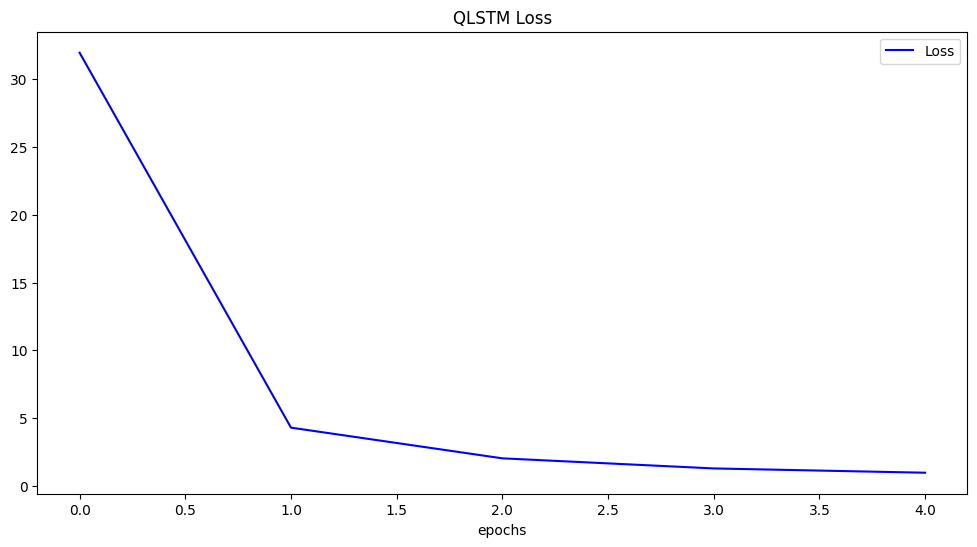

In [24]:
np.savetxt('./SavedModels/Madrid/loss/clstm_attn.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [25]:
print(len(X_test))
print(len(X_train))
print(len(y_train))
#print(X_train[0].unsqueeze(0))
#print(y_train[0].unsqueeze(0))

1008
4060
4060


In [26]:
def predict(X,y, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for i in range(len(X)):
            y_star = model(X[i].unsqueeze(0),y[i].unsqueeze(0))
            '''if list(y_star.size()) == [1,1]:
                y_star = y_star.tolist()
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star = torch.tensor(y_star)'''
            output = torch.cat((output, y_star), 0)


    return output

In [27]:
pred_y_test = predict(X_test,y_test, modelQ)
print(len(pred_y_test))
print(pred_y_test)

1008
tensor([[-1.3542e+00],
        [-1.4692e+00],
        [-1.5280e+00],
        ...,
        [ 6.4765e-04],
        [-2.1003e-01],
        [-2.1323e-01]])


In [28]:
pred_y_train = predict(X_train,y_train, modelQ)
print(len(pred_y_train))
print(pred_y_train)

4060
tensor([[-0.6880],
        [-0.3333],
        [ 0.0204],
        ...,
        [ 1.3773],
        [ 1.4881],
        [ 1.6428]])


In [29]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [30]:
print(len(pred_y_train))
print(len(y_train))

4060
4060


In [31]:
pred_y_test

tensor([[-1.3542e+00],
        [-1.4692e+00],
        [-1.5280e+00],
        ...,
        [ 6.4765e-04],
        [-2.1003e-01],
        [-2.1323e-01]])

In [32]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [33]:
np.savetxt('./SavedModels/Madrid/train/clstm_attn.txt',y_train_pred)
np.savetxt('./SavedModels/Madrid/test/clstm_attn.txt',y_test_pred)

Training dataset RMSE:0.09966997385894903


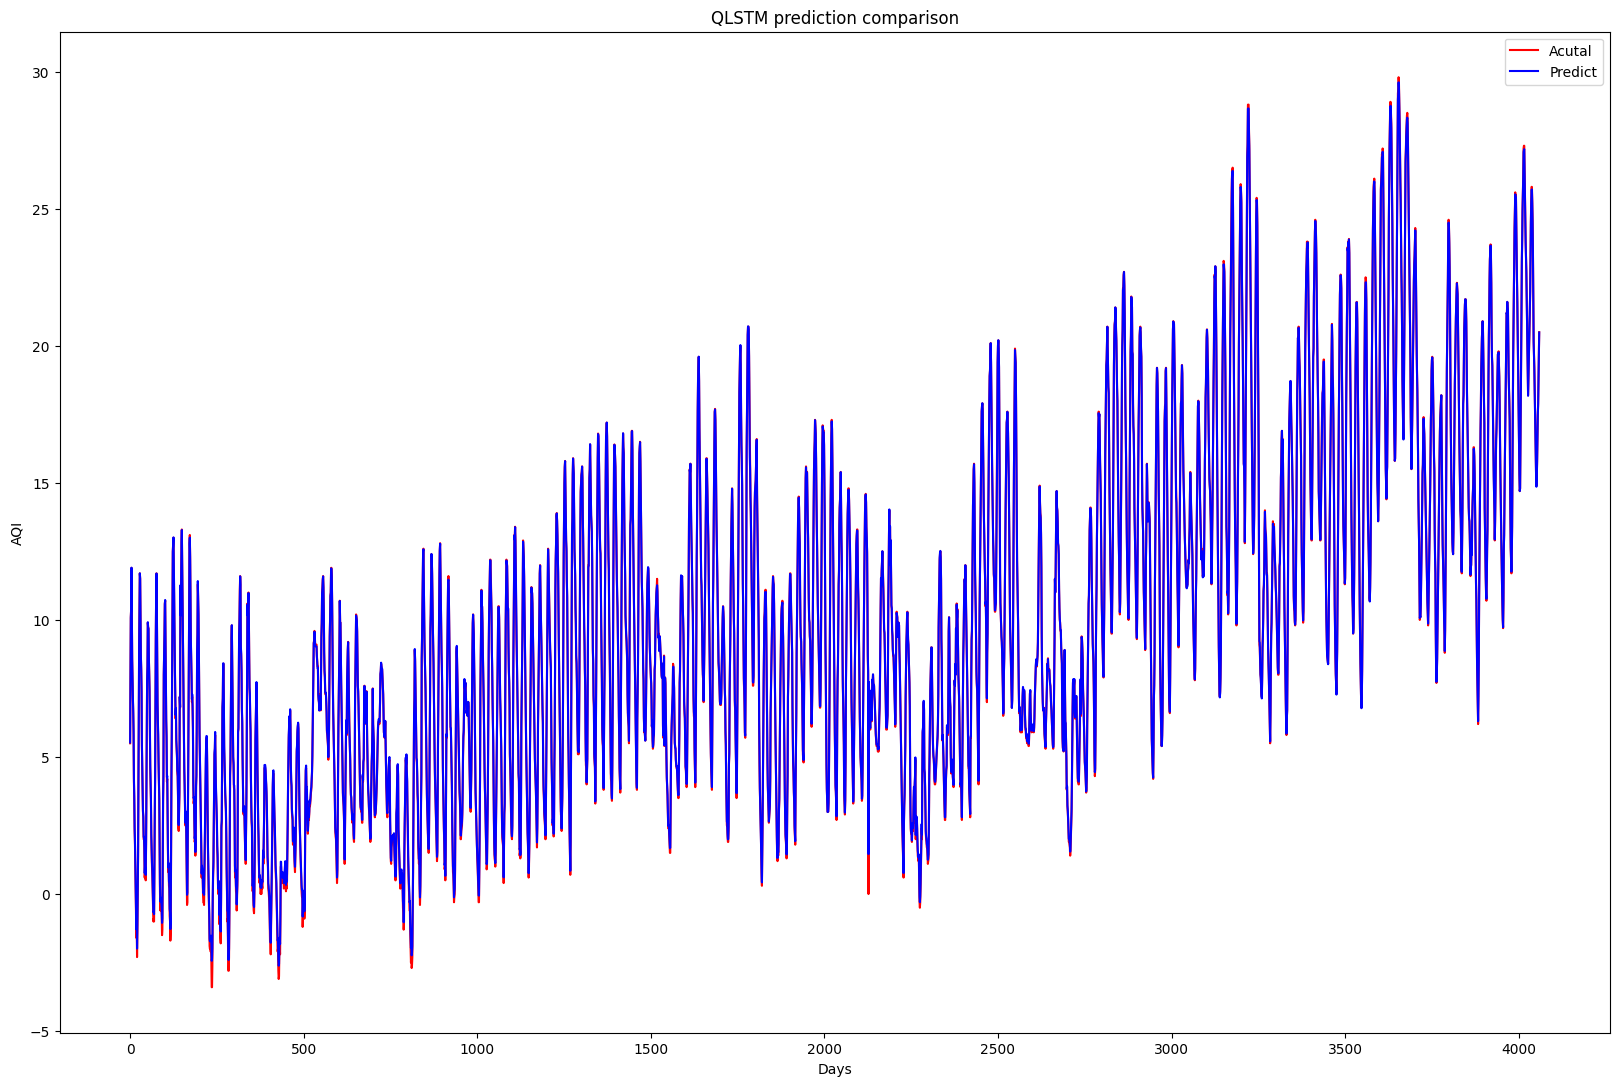

In [34]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:0.100051366572749


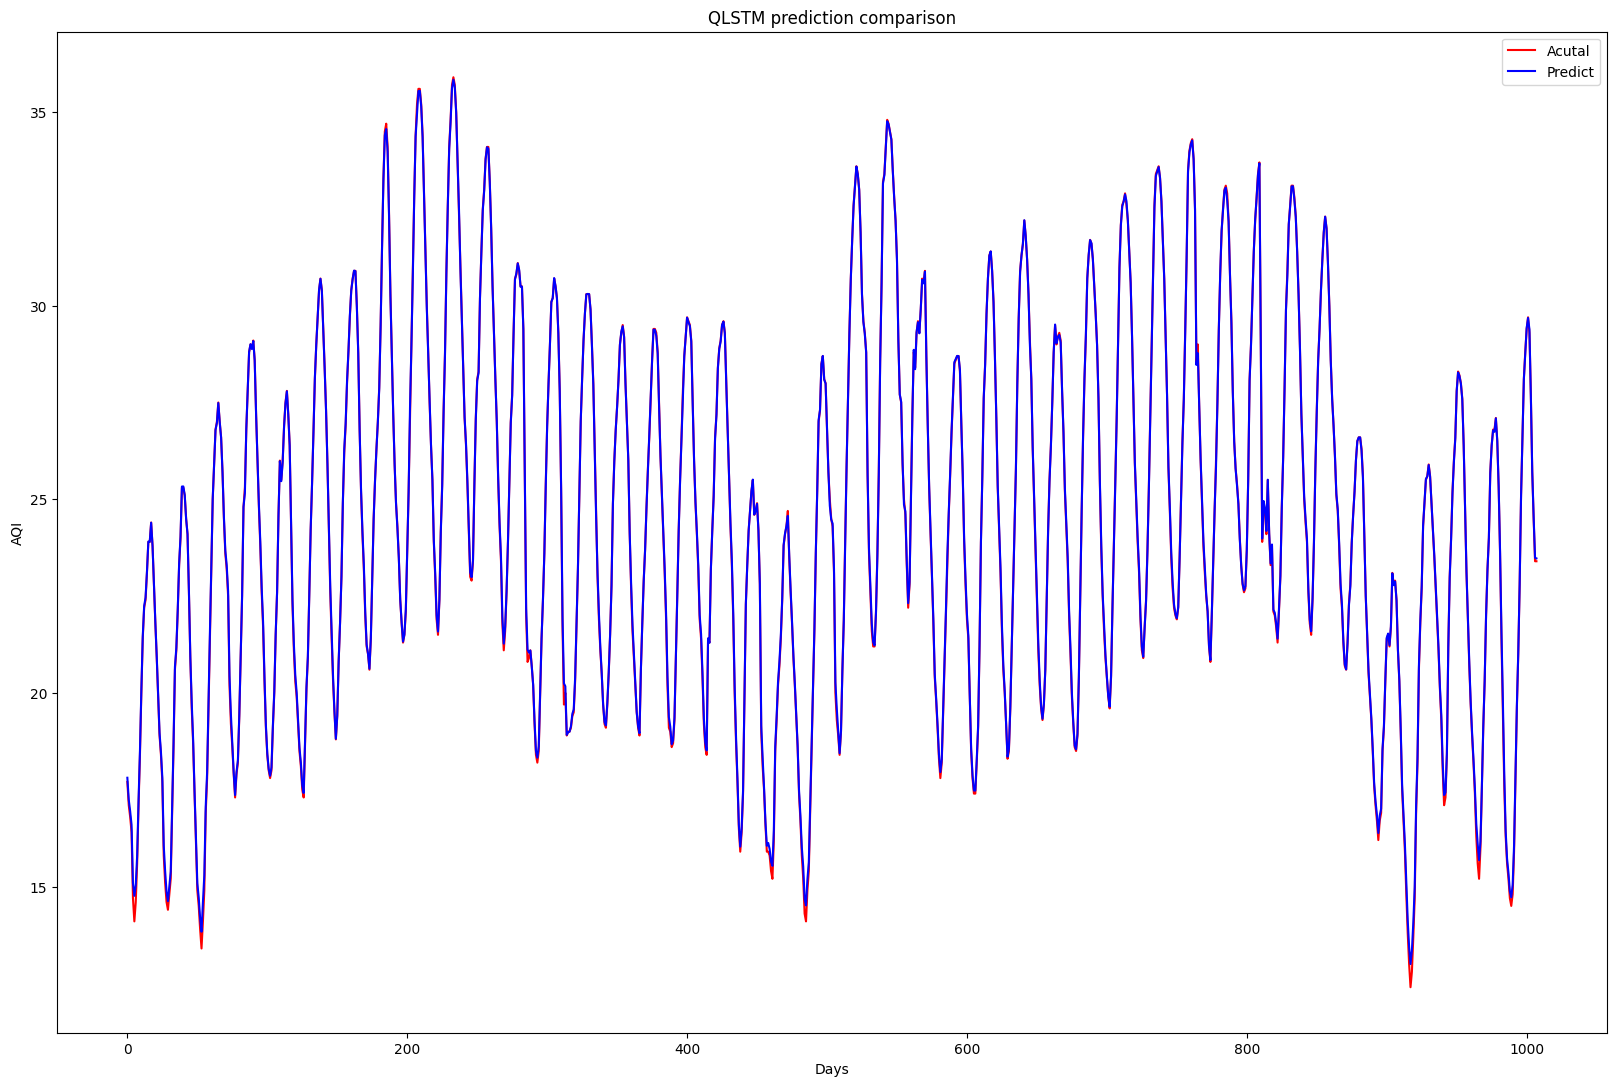

In [35]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [36]:
torch.save(modelQ,'./SavedModels/Madrid/model/CLSTM_attn')